In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [84]:
# Read data of all shots during the 2018-19 NBA season
data = pd.read_csv('nba_shotchartdetail_2018-19.csv')

In [85]:
# Specify columns of interest
cols = ['PLAYER_NAME', 'TEAM_NAME', 'PERIOD', 'SHOT_TYPE', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
               'LOC_X', 'LOC_Y', 'SHOT_MADE_FLAG']

data = data[cols]
data = data.rename(columns = {'PLAYER_NAME': 'player', 'TEAM_NAME': 'team', 'PERIOD': 'quarter', 'SHOT_TYPE': 'type',
                    'SHOT_ZONE_RANGE': 'range', 'SHOT_DISTANCE': 'distance', 'LOC_X': 'x', 'LOC_Y': 'y',
                    'SHOT_MADE_FLAG': 'made'})

In [86]:
# Create x-y grid over half-court
xgrid = np.arange(-250.5, 250.5, 25)
ygrid = np.arange(-50.5, 860.5, 30)

In [87]:
X = []; Y = []
# Find the X-Y grid coordinates of all shots
for x, y in zip(data['x'], data['y']):
    
    tempx = min(abs(xgrid - x))   
    idx = [i for i, val in enumerate(abs(xgrid - x)) if val == tempx]
    X.append(float(xgrid[idx[0]]))
    
    tempy = min(abs(ygrid - y))   
    idx = [i for i, val in enumerate(abs(ygrid - y)) if val == tempy]
    Y.append(float(ygrid[idx[0]]))

In [88]:
# Append coordinates to DataFrame
data['X'] = X
data['Y'] = Y

In [89]:
# Group data by zones
zones = data.groupby(['X', 'Y'])

In [90]:
zone = []
i = 0
for name, df in zones:
    zone.append([i, name[0], name[1], round(df['distance'].mean(), 2), df['made'].mean(), len(df)])
    i += 1

In [204]:
zone_data = pd.DataFrame(zone, columns = ['name', 'X', 'Y', 'distance', 'FG%', 'shots']).sort_values('distance')
zone_data.head()

,name,X,Y,distance,FG%,shots
216,216,-0.5,-20.5,0.06,0.621646,6708
217,217,-0.5,9.5,0.77,0.722983,37532
189,189,-25.5,-20.5,1.67,0.585903,227
243,243,24.5,-20.5,1.70,0.556122,196
190,190,-25.5,9.5,1.82,0.525029,9489


In [205]:
distance_th = np.arange(np.floor(zone_data.distance.min()), np.ceil(zone_data.distance.max() + 2), 2) + 0.15
shots_distance = np.array([zone_data[(zone_data['distance'] >= bottom) & (zone_data['distance'] < top)].shots.sum() / zone_data.shots.sum() for bottom, top in zip(distance_th[:-1], distance_th[1:])])

shots_fg, scores = [], []
for bottom, top in zip(distance_th[:-1], distance_th[1:]) :
    df = zone_data[(zone_data['distance'] >= bottom) & (zone_data['distance'] < top)]
    df['weighted_sum'] = df['FG%'] * df['shots']
    shots_fg.append(df['weighted_sum'].sum() / df['shots'].sum())
    if top <= 22.15:
        scores.append(2)
    else :
        scores.append(3)

shots_fg = np.array(shots_fg)
scores = np.array(scores)

In [207]:
distance_th

array([ 0.15,  2.15,  4.15,  6.15,  8.15, 10.15, 12.15, 14.15, 16.15,
       18.15, 20.15, 22.15, 24.15, 26.15, 28.15, 30.15, 32.15, 34.15,
       36.15, 38.15, 40.15, 42.15, 44.15, 46.15, 48.15, 50.15, 52.15,
       54.15, 56.15, 58.15, 60.15, 62.15, 64.15, 66.15, 68.15, 70.15,
       72.15, 74.15, 76.15, 78.15, 80.15, 82.15, 84.15, 86.15])

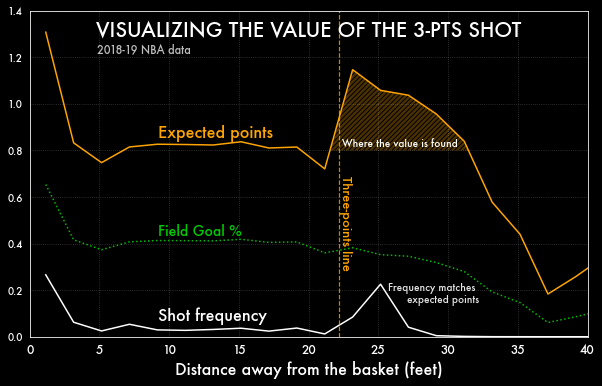

In [284]:
fig, ax = plt.subplots(figsize = (10, 6), facecolor = 'black')
plt.gca().set_facecolor('black')
plt.xlim([0, 40])
plt.ylim([0, 1.4])
ax.spines['left'].set_color('white'); ax.spines['right'].set_color('white')
ax.spines['bottom'].set_color('white'); ax.spines['top'].set_color('white') 

plt.plot(distance_th[:-1] + 1, shots_distance, color = 'white', label = 'Shot frequency')
plt.plot(distance_th[:-1] + 1, shots_fg, color = 'lime', label = 'Field goal %', alpha = 0.75, linestyle = ':')
plt.plot(distance_th[:-1] + 1, scores * shots_fg, color = 'orange', label = 'Expected points')

plt.annotate('Shot frequency', xy = (0.23, 0.05), fontname = 'futura', color = 'white', xycoords = 'axes fraction', size = 16)
plt.annotate('Field Goal %', xy = (0.23, 0.31), fontname = 'futura', color = 'lime', xycoords = 'axes fraction', size = 14, alpha = 0.8)
plt.annotate('Expected points', xy = (0.23, 0.61), fontname = 'futura', color = 'orange', xycoords = 'axes fraction', size = 16)

plt.plot([22.15, 22.15], [0, 1.4], color = 'orange', linestyle = '--', alpha = 0.8, linewidth = 1.2)
plt.annotate('Three-points line', xy = (22.2, 0.3), fontname = 'futura', color = 'orange', size = 13, rotation = 270)

plt.xlabel('Distance away from the basket (feet)', color = 'white', fontname = 'futura', size = 16)
plt.xticks(color = 'white', fontname = 'futura', size = 12)
#plt.ylabel('Frequency of shots', color = 'white', fontname = 'futura')
plt.yticks(color = 'white', fontname = 'futura')
plt.grid(linestyle = ':', color = 'white', alpha = 0.25)

x = (distance_th[:-1] + 1)[10:]
y1 = np.array(len(scores) * [0.8])[10:]
y2 = (scores * shots_fg)[10:]
ax.fill_between(x, y1, y2, where = y2 >= y1, facecolor = 'orange', interpolate = True, alpha = 0.3, hatch = '/////')
plt.annotate('Where the value is found', xy = (0.56, 0.58), fontname = 'futura', color = 'white', xycoords = 'axes fraction', size = 10)

plt.annotate('Frequency matches \nexpected points', xy = (0.805, 0.105), fontname = 'futura', color = 'white', xycoords = 'axes fraction', size = 10, ha = 'right', alpha = 0.9)

title = 'VISUALIZING THE VALUE OF THE 3-PTS SHOT'
plt.annotate(title, xy = (0.5, 0.92), fontname = 'futura', color = 'white', xycoords = 'axes fraction', size = 20, ha = 'center')
plt.annotate('2018-19 NBA data', xy = (0.12, 0.87), fontname = 'futura', color = 'white', xycoords = 'axes fraction', size = 11, ha = 'left', alpha = 0.75)

#plt.plot([1, 22.15, 22.15, 40], [2/3, 2/3, 1, 1], color = 'white', alpha = 0.25, linestyle = '-')

plt.savefig('value_3pt.jpeg', dpi = 500)
plt.show()

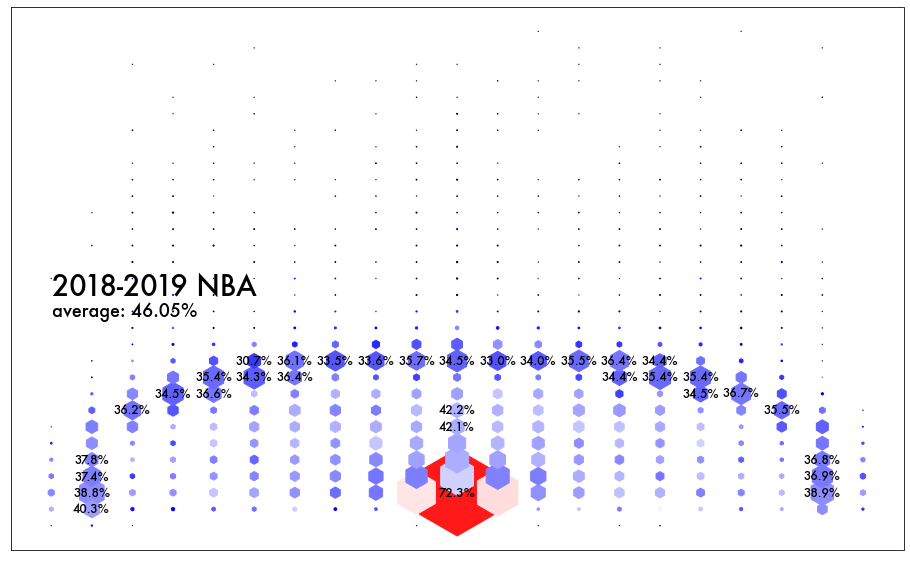

In [287]:
fig = plt.figure(figsize = (16, 10))

plt.scatter(zone_data['X'], zone_data['Y'], s = 0.2*zone_data['shots'], c = zone_data['FG%'], marker = 'h',
            cmap = 'seismic')

plt.xticks([])
plt.yticks([])

for fg, x, y, v, d in zip(zone_data['FG%'], zone_data['X'], zone_data['Y'], zone_data['shots'], zone_data['distance']):
    if  v > 1000 and d > 10 or v == max(zone_data['shots']):
        plt.annotate(str(round(100*fg, 1)) + '%', xy = (x,y), fontname = 'futura', ha = 'center', va = 'center', size = 12)
 

fg_lg = round(100*data['made'].mean(), 2)
plt.annotate('average: ' + str(fg_lg) + '%', xy = (-250, 330), fontname = 'futura', size = 18)
plt.annotate('2018-2019 NBA', xy = (-250, 370), fontname = 'futura', size = 28)
plt.savefig('shot_map_v1.png', dpi = 200)

plt.show()